# Detecting COVID-19 in X-ray images

### Description:

- __Covid-19 x_ray images source - https://github.com/ieee8023/covid-chestxray-dataset__
- __Normal x_ray images source - https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia__
    
__Data__: The Dataset used here contains x-ray images from two sources. 
    The COVID-19 x-ray images are used from the above github repo, the images are collected by *Dr. Joseph Cohen* and 
    the normal x-ray images are used from *Chest X-Ray Images (Pneumonia)* dataset by Paul Mooney

- __All the x-ray images used have *Anterior-Posterior* view__

In [1]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
from google.colab import files
files.upload()

In [1]:
%cd "/content/drive/My Drive/covid_xray/"

/content/drive/My Drive/covid_xray


In [107]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from GradCAM.gradcam import GradCAM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import tensorflow.keras.applications.vgg16 as imagenet_utils
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import recall_score, accuracy_score, f1_score
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Reading Data

In [108]:
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[1]

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [109]:
dataset = pd.DataFrame()
dataset['data'] = data
dataset['labels'] = labels

#seperating covid postive and normal patient data
covid = dataset[dataset['labels'] == 'covid']
normal = dataset[dataset['labels'] == 'normal']

In [ ]:
covid.head(5)

data labels
0  [[[133, 133, 133], [122, 122, 122], [115, 115,...  covid
1  [[[51, 51, 51], [52, 52, 52], [50, 50, 50], [5...  covid
2  [[[7, 7, 7], [3, 3, 3], [3, 3, 3], [3, 3, 3], ...  covid
3  [[[44, 42, 43], [53, 51, 52], [57, 55, 56], [5...  covid
4  [[[104, 104, 104], [102, 102, 102], [102, 102,...  covid

In [ ]:
normal.head(5)

data  labels
180  [[[6, 6, 6], [4, 4, 4], [20, 20, 20], [27, 27,...  normal
181  [[[22, 22, 22], [1, 1, 1], [0, 0, 0], [0, 0, 0...  normal
182  [[[60, 60, 60], [57, 57, 57], [51, 51, 51], [5...  normal
183  [[[111, 111, 111], [112, 112, 112], [108, 108,...  normal
184  [[[9, 9, 9], [13, 13, 13], [22, 22, 22], [30, ...  normal

There are 180 x-ray images of normal patients and 180 x-ray images of Covid-19 positive patients
---------------------------------------------------------


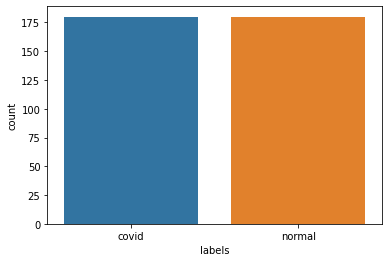

In [ ]:
print("There are {} x-ray images of normal patients and {} x-ray images of Covid-19 positive patients".format(len(normal), len(covid)))
print('-'*57)
ax = sns.countplot(x="labels", data=dataset)

- As we can see the dataset is perfectly balanced there are 180 images for each class

## Visualizing Data

__Normal Patients__

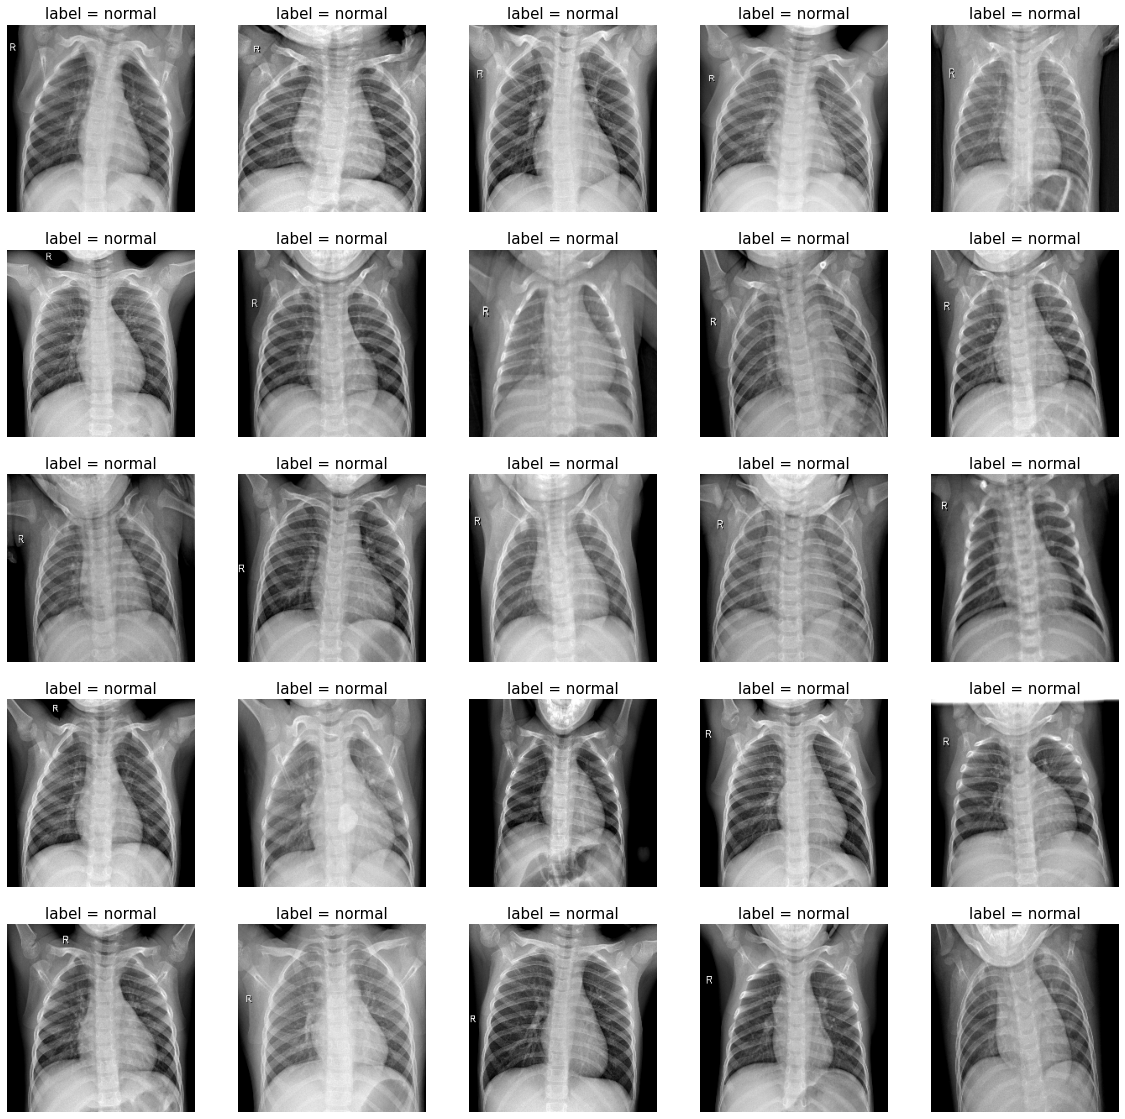

In [91]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (20,20))
axes = axes.ravel() # 

for i in np.arange(0, L * W):  
    axes[i].imshow(normal.data.values[i])
    axes[i].set_title('label = {}'.format(normal.labels.values[i]), fontsize = 15)
    axes[i].axis('off')

__Covid Positive Patients__

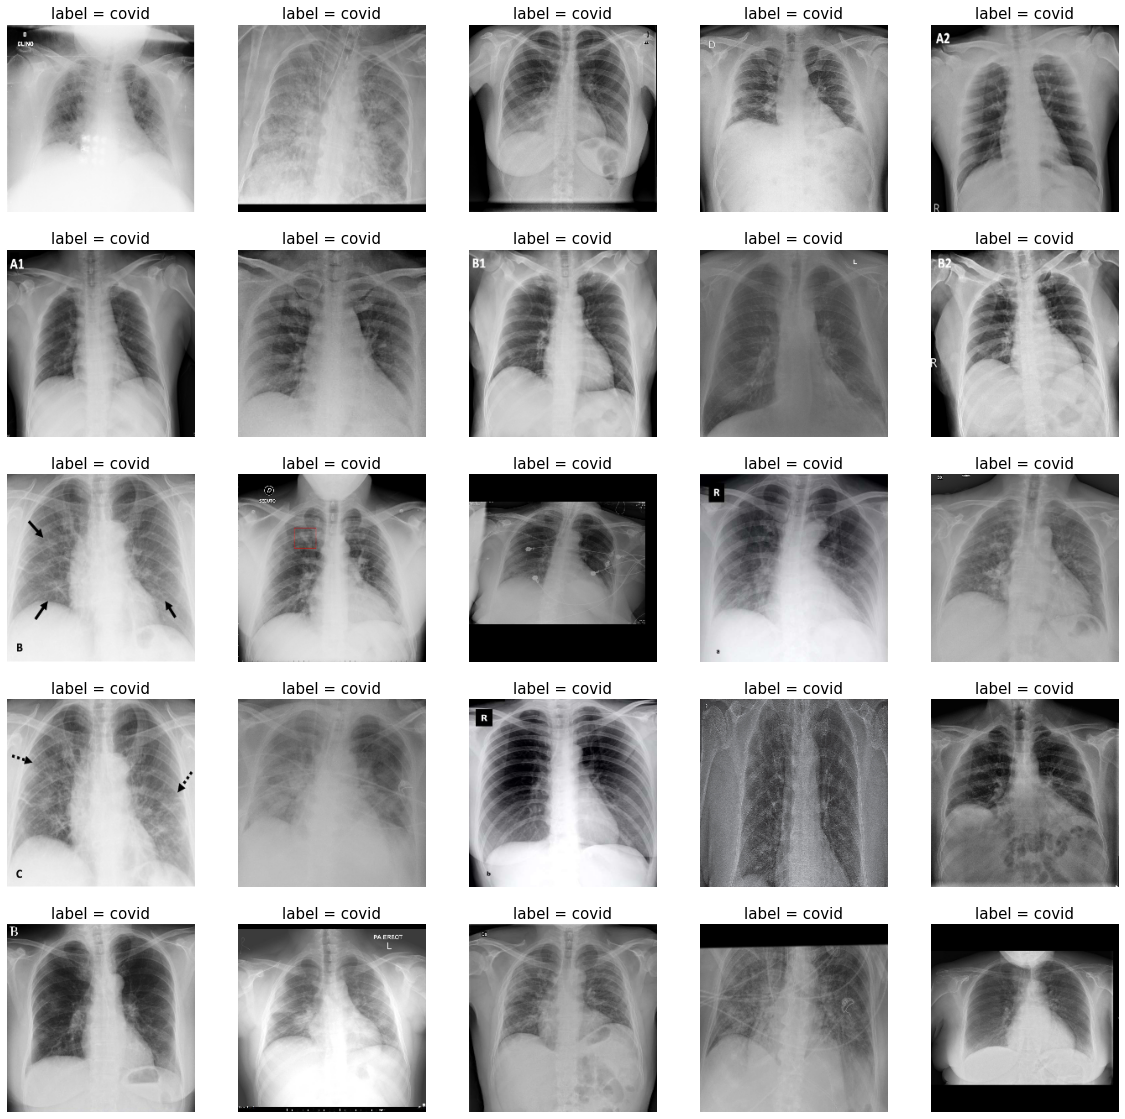

In [92]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (20,20))
axes = axes.ravel() # 

for i in np.arange(0, L * W):  
    axes[i].imshow(covid.data.values[i])
    axes[i].set_title('label = {}'.format(covid.labels.values[i]), fontsize = 15)
    axes[i].axis('off')

## Building Model

In [126]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = ['normal','covid']
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={'size':14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={'size':14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={'size':14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    print('Accuracy: ', accuracy_score(test_y,predict_y))
    print('Recall: ', recall_score(test_y,predict_y))
    print('Precision: ', precision_score(test_y,predict_y))
    print('Specificity: ', C[1, 1] / (C[1, 0] + C[1, 1]))
    print('F1 score: ', f1_score(test_y, predict_y))
    
    plt.show()

In [127]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(dataset.data.to_list()) / 255.0
labels = np.array(dataset.labels)

In [128]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [129]:
# splitting the data into training and testing 
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

In [130]:
# image data augmentation
datagen = ImageDataGenerator(rotation_range=15,
                             zoom_range = 0.2,
                             fill_mode="nearest")

In [131]:
# load the VGG16 network
vgg_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
vgg_model.trainable = False

In [132]:
x = vgg_model.output
x = AveragePooling2D(pool_size=(4, 4))(x)
x = Flatten()(headModel)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(headModel)
model_output = Dense(2, activation="softmax")(x)

In [133]:
model = Model(inputs=vgg_model.input, outputs=model_output)

In [135]:
# compile our model
model.compile(optimizer=Adam(lr=0.001, decay=0.001 / 25), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_753"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [136]:
batch_size = 20
epoch = 30

In [137]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 6, restore_best_weights=True, verbose=1)

train_model = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                                  steps_per_epoch=len(x_train) // batch_size,
                                  validation_data=(x_test, y_test), validation_steps=len(x_test) // batch_size, 
                                  epochs=epoch, callbacks = [es])

Epoch 1/30
12/12 [==============================] - 3s 243ms/step - loss: 0.8263 - accuracy: 0.5129 - val_loss: 0.6166 - val_accuracy: 0.7778
Epoch 2/30
12/12 [==============================] - 3s 219ms/step - loss: 0.6285 - accuracy: 0.6509 - val_loss: 0.5052 - val_accuracy: 0.8426
Epoch 3/30
12/12 [==============================] - 3s 220ms/step - loss: 0.5403 - accuracy: 0.7414 - val_loss: 0.4278 - val_accuracy: 0.8889
Epoch 4/30
12/12 [==============================] - 3s 222ms/step - loss: 0.4389 - accuracy: 0.8190 - val_loss: 0.3704 - val_accuracy: 0.9259
Epoch 5/30
12/12 [==============================] - 3s 223ms/step - loss: 0.4282 - accuracy: 0.8190 - val_loss: 0.3248 - val_accuracy: 0.9537
Epoch 6/30
12/12 [==============================] - 3s 227ms/step - loss: 0.3844 - accuracy: 0.8319 - val_loss: 0.2979 - val_accuracy: 0.9537
Epoch 7/30
12/12 [==============================] - 3s 225ms/step - loss: 0.3360 - accuracy: 0.8875 - val_loss: 0.2655 - val_accuracy: 0.9537
Epoch 

In [138]:
# predictions on the testing set
preds = model.predict(x_test, batch_size=batch_size)
pred_indx = np.argmax(preds, axis=1)

Accuracy:  0.9814814814814815
Recall:  0.9814814814814815
Precision:  0.9814814814814815
Specificity:  0.9814814814814815
F1 score:  0.9814814814814815


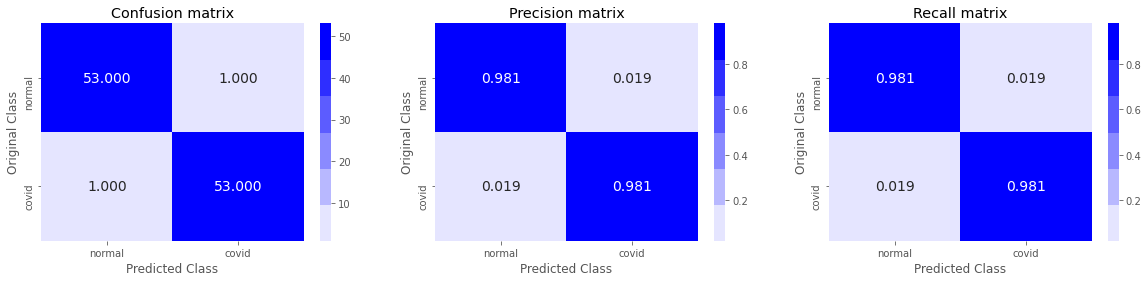

In [139]:
plot_confusion_matrix(y_test.argmax(axis=1), pred_indx)

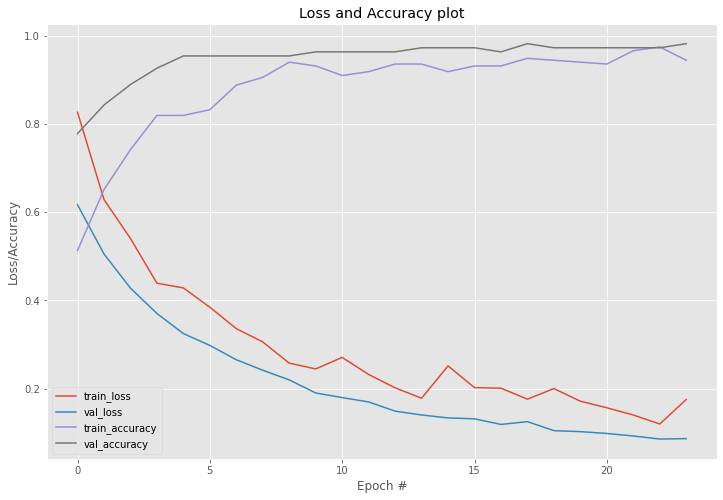

In [140]:
# plot the training loss and accuracy
N=24
plt.style.use("ggplot")
plt.figure(figsize=(12,8))
plt.plot(np.arange(N), train_model.history["loss"], label="train_loss")
plt.plot(np.arange(N), train_model.history["val_loss"], label="val_loss")
plt.plot(np.arange(N), train_model.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(N), train_model.history["val_accuracy"], label="val_accuracy")
plt.title("Loss and Accuracy plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [1]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/covid_xray/model.json", "w") as json_file:
  json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/covid_xray/model_weights.h5")
print("Saved model to disk")

Saved model to disk


## Interpreting CNN model

### Gradient-weighted Class Activation Mapping (Grad-CAM)

- __Here we will use GradCAM to interpret our CNN model__
- __GradCAM uses the gradient information of a target flowing into the last convolutional layer to produce a coarse localization map highlighting the important regions in images__
- __GradCAM helps us to understand visually, what are the features in images, that our model considers important__
- __It helps us to understand how the model arrived at its final output and what exactly was it looking for in the images to classify them as covid positive or normal__

In [71]:
model = VGG16(weights="imagenet")

def GradCAM_images(start, end):
  cam_images = []
  for i in range(start,end):
    og_image = cv2.imread(imagePaths[i])
    resized = cv2.resize(og_image, (224, 224))

    image = np.expand_dims(resized, axis=0)
    image = imagenet_utils.preprocess_input(image)

    preds = model.predict(image)
    indx = np.argmax(preds[0])

    cam = GradCAM(model, indx)
    heatmap = cam.compute_heatmap(image)

    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

    cam_images.append(output)

  return cam_images


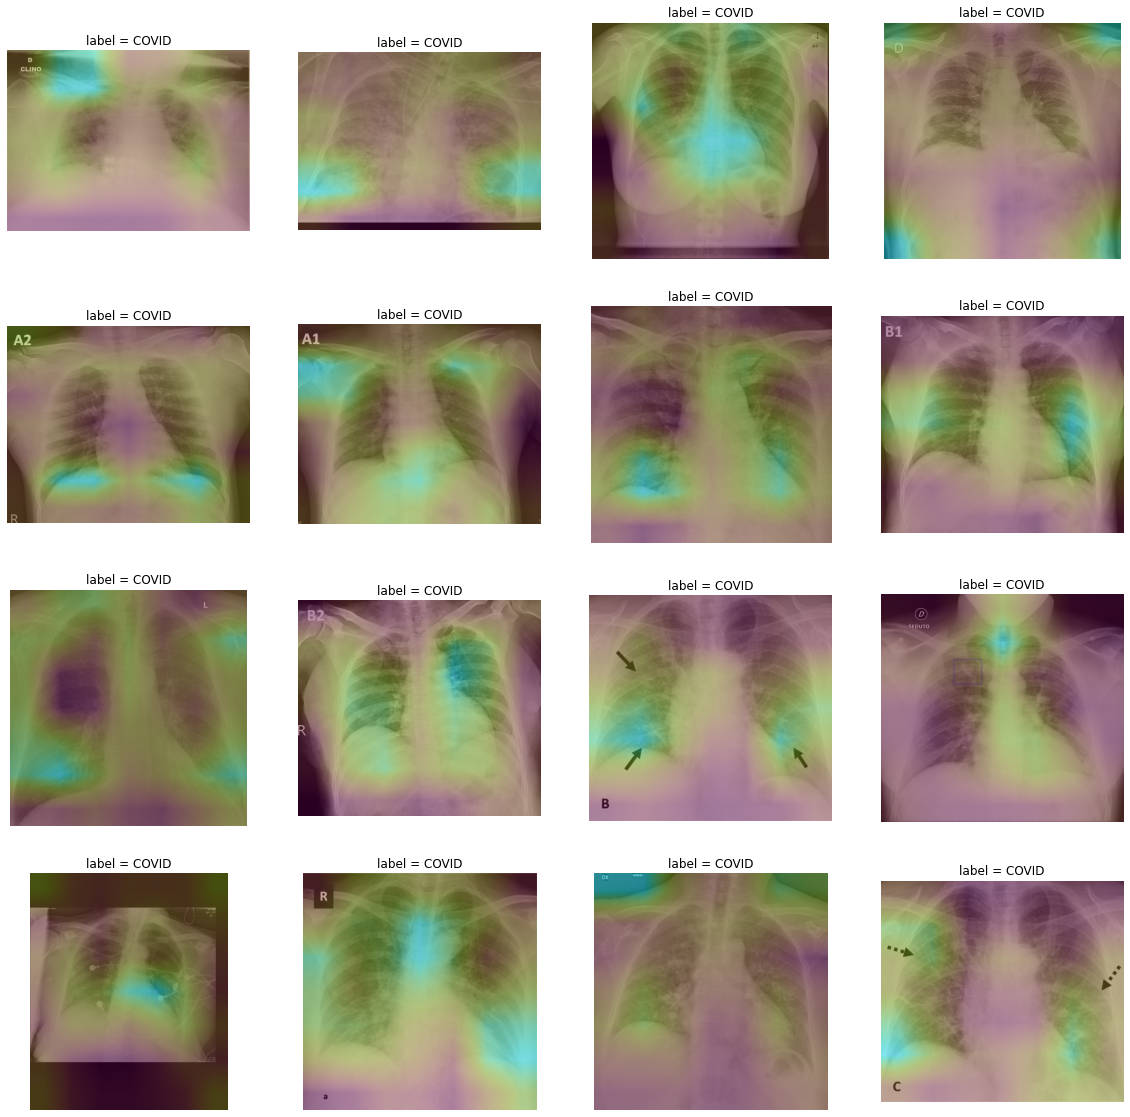

In [88]:
L = 4
W = 4
cam_images = GradCAM_images(0,17)
fig, axes = plt.subplots(L, W, figsize = (20,20))
axes = axes.ravel() # 

for i in np.arange(0, L * W):  
    axes[i].imshow(cam_images[i], cmap ='Greys')
    axes[i].set_title('label = {}'.format('COVID'))
    axes[i].axis('off')

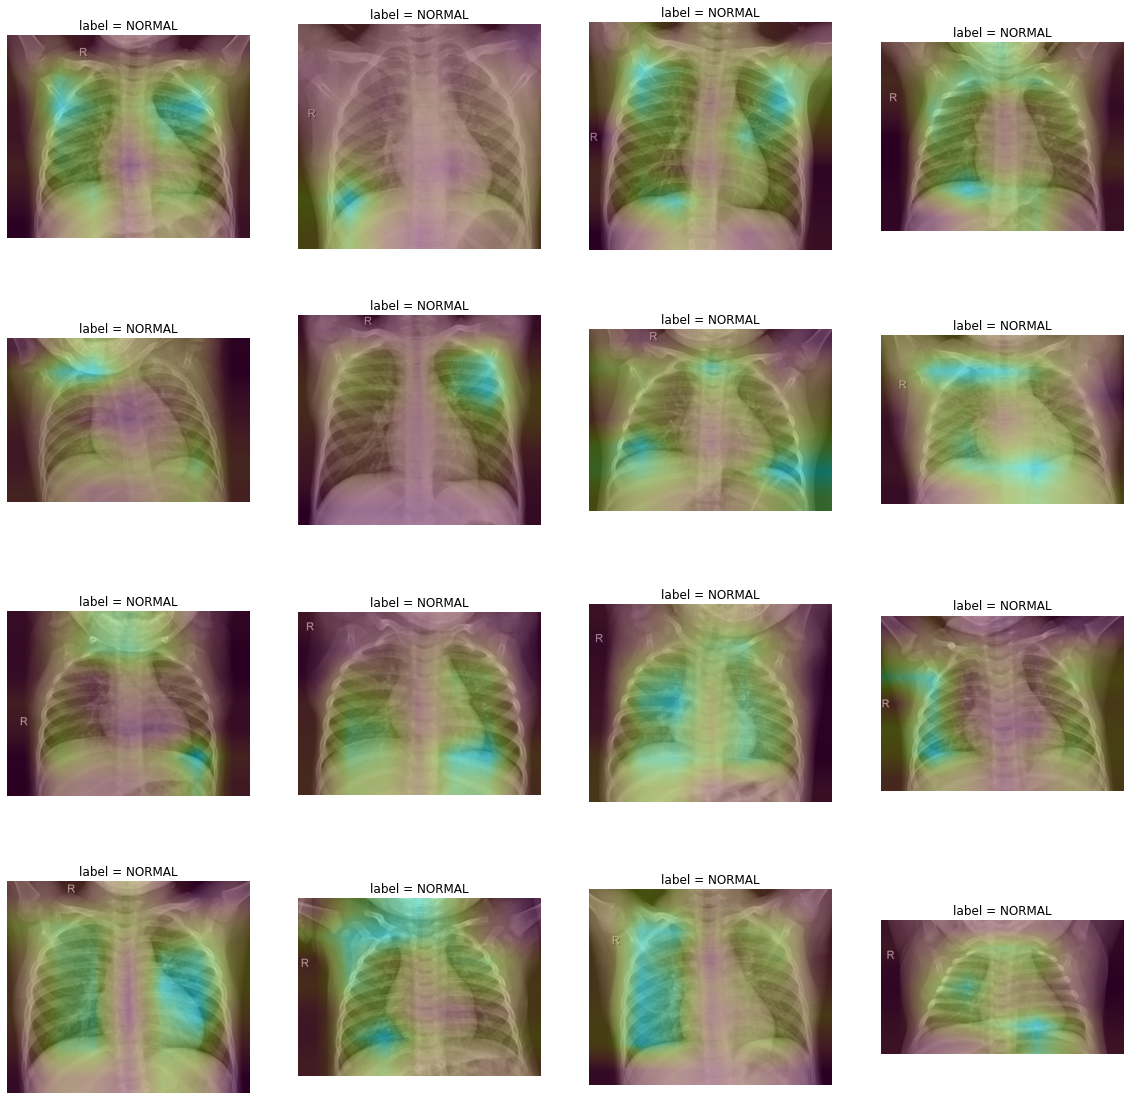

In [86]:
L = 4
W = 4
cam_images = GradCAM_images(200,217)
fig, axes = plt.subplots(L, W, figsize = (20,20))
axes = axes.ravel() # 

for i in np.arange(0, L * W):  
    axes[i].imshow(cam_images[i], cmap ='Greys')
    axes[i].set_title('label = {}'.format('NORMAL'))
    axes[i].axis('off')

## Summary

- __As we can see the Model has a very high accuracy, precision and recall score__
- __Here the Test data contains 108 x-ray images of patients out of which 106 images were perfectly classified into covid  positive and negative__
- __We used GradCAM to visually understand the predictions and highlight the important regions in images__
- __further we can use more images and more data such as clinical notes, gender, bloodgroup, etc. of patients to make the model robust__